# Sieci neuronowe i Deep Learning
# Temat 6: PyTorch dla bardziej zaawansowanych

Potrzebne pakiety i ich rekomendowane minimalne wersje:
`numpy`: 1.21.2,
`matplotlib`: 3.4.3,
`torch`: 1.8,
`mlxtend`: 0.19.0.

## Graf obliczeniowy w bibliotece PyTorch

### Tworzenie grafu w PyTorch

Przeanalizujemy prosty przykład tworzenia grafu obliczeniowego dla wyrażenia
$$z = 2(a-b)+c.$$
Skalary $a$, $b$, $c$ zdefiniowane zostaną jako tensory (rzędu 0).

In [1]:
import torch

In [2]:
# Definiujemy standardową funkcję w Pythonie:
def compute_z(a, b, c):
    r1 = torch.sub(a, b)
    r2 = torch.mul(r1, 2)
    z = torch.add(r2, c)
    return z

PyTorchowe funkcje
`add`, `sub` (lub `subtract`), `mul` (lub `multiply`)
obsługują oczywiście także tensory wyższych rzędów.

In [3]:
# Kilka przykładów wywołań zdefiniowanej funkcji:
print('Scalar Inputs:', compute_z(torch.tensor(1), torch.tensor(2), torch.tensor(3)))
print('Rank 1 Inputs:', compute_z(torch.tensor([1]), torch.tensor([2]), torch.tensor([3])))
print('Rank 2 Inputs:', compute_z(torch.tensor([[1]]), torch.tensor([[2]]), torch.tensor([[3]])))

Scalar Inputs: tensor(1)
Rank 1 Inputs: tensor([1])
Rank 2 Inputs: tensor([[1]])


## Tensory w PyTorch do przechowywania i aktualizowania parametrów modeli ML

Tensory, dla których chcemy liczyć gradienty, w bibliotece PyTorch tworzymy, specyfikując parametr `requires_grad=True`.

In [4]:
a = torch.tensor(3.14, requires_grad=True)
b = torch.tensor([1.0, 2.0, 3.0], requires_grad=True) 
print(a)
print(b)

tensor(3.1400, requires_grad=True)
tensor([1., 2., 3.], requires_grad=True)


In [5]:
a.requires_grad

True

In [6]:
w = torch.tensor([1.0, 2.0, 3.0])

print(w.requires_grad)

False


In [7]:
w.requires_grad_()

print(w.requires_grad)

True


Losowe inicjalizowanie wag jest standardową praktyką w procesie tworzenia i uczenia sieci neuronowych, szczególnie przy stosowaniu algorytmów takich jak propagacja wsteczna błędu.

W bibliotece PyTorch możliwe jest generowanie tensorów o losowych wartościach.

**Inicjalizacja Glorota**

In [8]:
import torch.nn as nn

# Najpierw tworzymy pusty tensor:
w = torch.empty(2, 3)

# Następnie tworzymy obiekt o nazwie `init` klasy `GlorotNormal`
# i uruchamiamy na nim metodę `xavier_normal_()`:
nn.init.xavier_normal_(w)

print(w)

tensor([[-0.3832, -0.0260, -0.9936],
        [ 0.1295, -1.5207, -0.4793]])


W praktyce, np., gdy definiujemy klasę pochodną od `nn.Module`:

In [9]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.empty(2, 3, requires_grad=True)
        nn.init.xavier_normal_(self.w1)
        self.w2 = torch.empty(1, 2, requires_grad=True)
        nn.init.xavier_normal_(self.w2)

# - te dwa tensory mogą następnie zostać użyte jako wagi, dla których będą liczone gradienty i robiona aktualizacja

## Obliczanie gradientów za pomocą automatycznego różniczkowania

### Liczenie gradientów funkcji straty względem parametrów modelu

Biblioteka PyTorch umożliwia liczenie gradientów tensorów wyliczanych w wyniku serii kolejnych operacji w odniesieniu do węzłów w odpowiadającym grafie obliczeniowym.

Do obliczania pochodnych cząstkowych (ich wartości) można wykorzystać metodę
`backward`
z modułu `torch.autograd`.

Zobrazujmy to na prostym przykładzie modelu
$z = wx + b$ i funkcji straty
$Loss = (y - z)^2$ (pojedyncza predykcja).

In [10]:
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True) 

# Jeden przykład uczący:
x = torch.tensor([1.4])
y = torch.tensor([2.1])


z = torch.add(torch.mul(w, x), b)
 
loss = (y-z).pow(2).sum()  # .sum() dla większej liczby przykładów uczących

In [11]:
loss.backward()

print('dL/dw : ', w.grad)
print('dL/db : ', b.grad)

dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)


## Budowanie modeli z wykorzystaniem klasy `nn.Sequential`

Inny sposób na budowanie jednokierunkowych sieci nauronowych - z wykorzystaniem klasy `nn.Sequential`:
proste, ale mniej elastyczne podejście niż z `nn.Module`. 

In [12]:
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU()
)
# To daje standardowo model ze wszystkimi połączeniami między warstwami

model  # Gotowa instancja modelu

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

**Konfiguracja warstw**

* Inicjalizacja wag: `nn.init`: https://pytorch.org/docs/stable/nn.init.html 
* Regularyzacja L1: `nn.L1Loss`: https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss
* Regularyzacja L2: `weight_decay`: https://pytorch.org/docs/stable/optim.html
* Funkcje aktywacji: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity  

I teraz możemy konfigurować nasz model:

In [13]:
# Ustawiamy inicjalizację wag w pierwszej warstwie:
nn.init.xavier_uniform_(model[0].weight)

# Dla drugiej warstwy liczymy karę L1:
l1_weight = 0.01  # Ustawiamy współczynnik regularyzacji L1
l1_penalty = l1_weight * model[2].weight.abs().sum()  # Obliczanie kary L1

**Optymalizatory i funkcje straty**

* Algorytmy optymalizacyjne: `torch.optim`: https://pytorch.org/docs/stable/optim.html#algorithms
* Funkcje straty: https://pytorch.org/docs/stable/nn.html#loss-functions

Wybieramy funkcję straty (MSE częściej dla regresji, cross-entropy dla klasyfikacji (będzie w dalszej części przedmiotu)) oraz optymalizator:

In [14]:
loss_fn = nn.BCELoss()  # Entropia krzyżowa dla klasyfikacji binarnej
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

## Problem klasyfikacyjny XOR (eXclusive OR, alternatywa rozłączna)

Podejście z wykorzystaniem klasy `nn.Sequential()`
oraz podejście z wykorzystaniem klasy `nn.Module()`



Generujemy 200 przykładów $(x_0, x_1)$ z rozkładu jednostajnego na kostce $[–1, 1)^2$ i
przypisujemy im etykiety zgodnie z regułą

$$
y^{(i)} =
\begin{cases}
0, & \text{jeśli } x_0^{(i)} x_1^{(i)} < 0, \\
1 & \text{w p.p.}
\end{cases}
$$

Powstały zbiór dzielimy na pół, tworząc zbiór treningowy oraz zbiór walidacyjny.

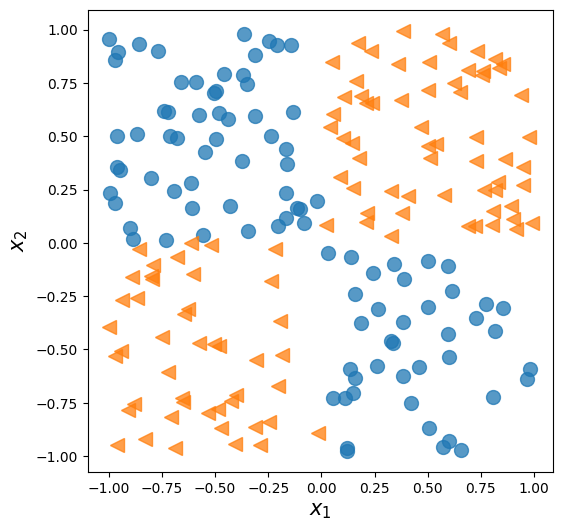

In [15]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(1)
torch.manual_seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], 
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], 
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)

plt.show()

In [16]:
# Przygotowanie danych pod budowę sieci neuronwych:
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

Zacznijmy od bardzo prostego modelu (jeden neuron z sigmoidalną funkcją aktywacji - regresja logistyczna):

In [17]:
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

Wybieramy funkcję straty (entropia krzyżowa dla klasyfikacji binarnej) oraz optymalizator (SGD):

In [18]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

Uruchamiamy uczenie (200 epok) i zapisujemy logi:

In [19]:
torch.manual_seed(1)

num_epochs = 200

def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Wykres historii uczenia (strata oraz dokładność - na obu zbiorach):

Text(0.5, 0, 'Epochs')

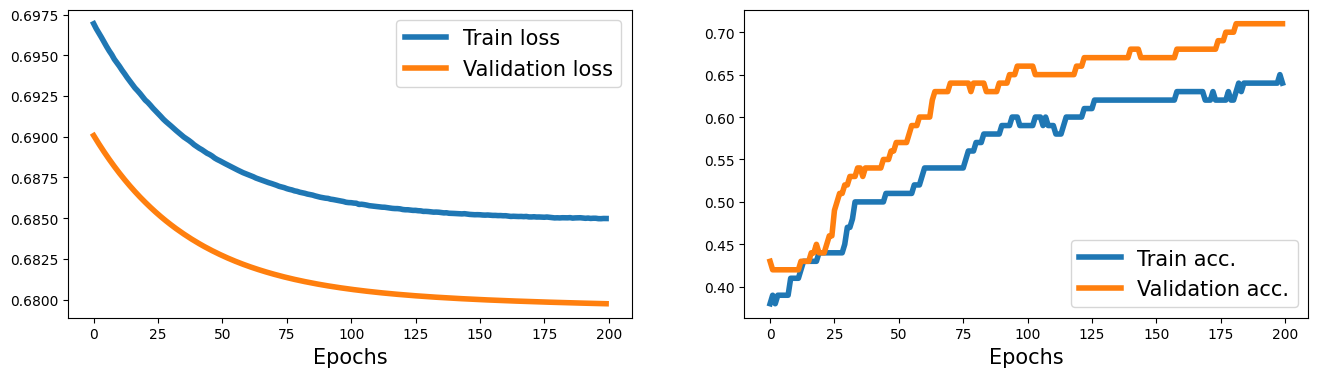

In [20]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

Wysoka strata, niska dokładność - tak jak można było się spodziewać po klasyfikatorze liniowym zastosowanym do problemy XOR.

Aby zbudować nieliniową granicę decyzyjną, możemy dodać ukryte warstwy o odpowiedniej liczbie neuronów.

Według ,,universal approximation theorem" jednokierunkowa sieć neuronowa z pojedynczą warstwą ukrytą i odpowiednio dużą liczbą neuronów w tej warstwie nadaje się do aproksymacji dowolnej funkcji ciągłej.

Możemy zwiększać głębokość lub szerokość rozważanej sieci; poniżej przykład z dwiema dwarstwami ukrytymi.

In [21]:
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [22]:
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

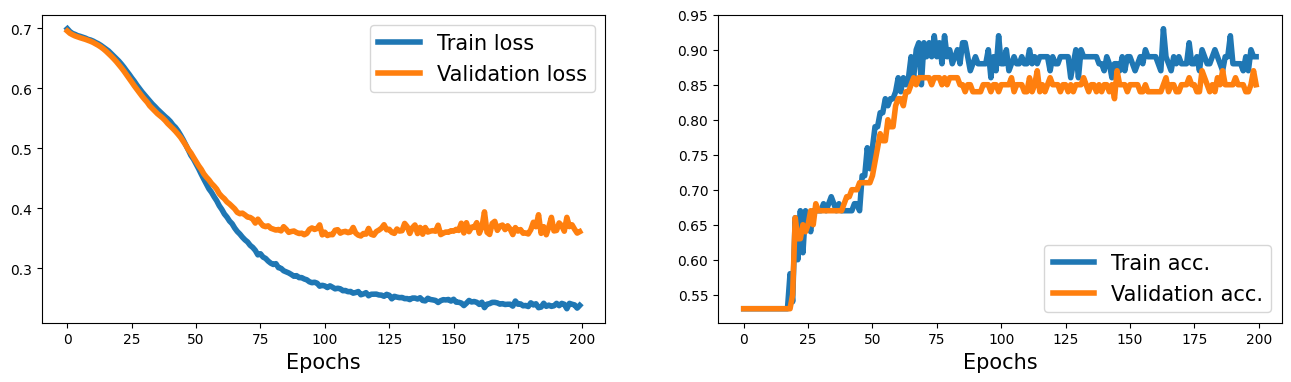

In [23]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

Po tych 200 epokach model jest nieco przeuczony.

Alternatywnym sposobem budowania modeli jest budowanie podklas klasy `nn.Module` (patrz temat 5).

Poniżej, dla przypomnienia tego podejścia, znajduje się kod dla rozważanego problemu XOR.

In [24]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)
        # Tym razem wszystkie warstwy umieszczamy w obiekcie
        # `nn.ModuleList` (lista składająca się z elementów `nn.Module`)
        # - dla zwiększenia czytelności

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()
            
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [25]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
    
# torch.manual_seed(1)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

In [71]:
!pip install mlxtend

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for mlxtend from https://files.pythonhosted.org/packages/1c/07/512f6a780239ad6ce06ce2aa7b4067583f5ddcfc7703a964a082c706a070/mlxtend-0.23.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.4 MB 330.3 kB/s eta 0:00:05
   -- ------------------------------------- 0.1/1.4 MB 476.3 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/1.4 MB 476.3 kB/s eta 0:00:03
   ---- ----------------------------------- 0.2/1.4 MB 579.6 kB/s eta 0:00:03
   ------ --------------------------------- 0.2/1.4 MB 754.9 kB/s eta 0:00:02
   --------- ------------------------------ 0.3/1.4 MB 8

In [77]:
!pip install --upgrade bottleneck

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for bottleneck from https://files.pythonhosted.org/packages/a7/ef/f5ee62f290f61842b34413ae82042825556ee1078e195d0e34c674fdc72e/Bottleneck-1.3.8-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/110.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/110.1 kB ? eta -:--:--
   ------- ------------------------------- 20.5/110.1 kB 330.3 kB/s eta 0:00:01
   ------- ------------------------------- 20.5/110.1 kB 330.3 kB/s eta 0:00:01
   --------------------- ----------------- 61.4/110.1 kB 365.7 kB/s eta 0:00:01
   -------------------------------- ------ 92.2/110.1 kB 438.1 kB/s eta 0:00:01
   -------------------------------------- 110.1/110.1 kB 458.2 kB/s eta 0:00:00


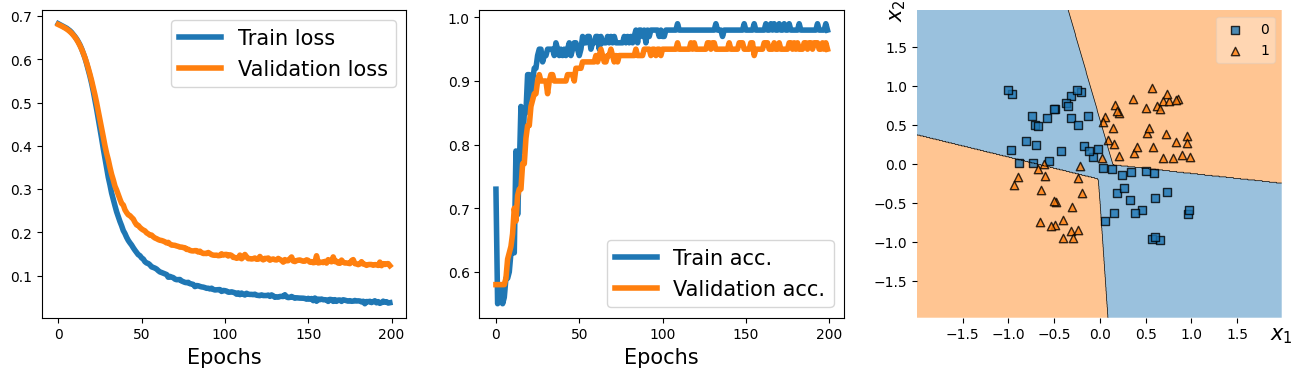

In [26]:
from mlxtend.plotting import plot_decision_regions


fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

plt.show()

Na trzecim rysunku znajdują się przykłady ze zbioru walidacyjnego wraz z granicami decyzyjnymi modelu.

## Definiowanie własnych (nowych) warstw w bibliotece PyTorch

Jeśli chcemy zdefiniować nową warstwę, która jeszcze nie jest bezpośrednio wspierana przez PyTorch, możemy to zrobić, wykorzystując klasę `nn.Module`.

Prosty przykład: liniowa warstwa, która dodaje szum do danych i oblicza
$w(x + \varepsilon) + b$. Można to zrobić na przykład tak jak pokazano poniżej.

In [27]:
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w)  # Tensor w zostanie dodawany do listy parametrów modułu
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev

    def forward(self, x, training=False):  # training=False, aby specyfikować, czy warstwa ma być używana do uczenia,
                                           # czy tylko do przewidywania/wnioskowania
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w), self.b)   

In [29]:
# Przetestujmy to.
# Tworzymy nową instancję warstwy i uruchamiamy ją trzy razy na zerowym tensorze wejściowym:

torch.manual_seed(1)

noisy_layer = NoisyLinear(4, 2)
 
x = torch.zeros((1, 4))
print(noisy_layer(x, training=True))

print(noisy_layer(x, training=True))
 
print(noisy_layer(x, training=False))

tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)
tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)


In [30]:
# Tworzymy nowy model, podobny do rozważanego wyżej dla XOR,
# ale tym razem dodamy naszą kastomową warstwę:

class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()
        
    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

torch.manual_seed(1)
model = MyNoisyModule()
model

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [31]:
# Uczymy:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
    
torch.manual_seed(1)

loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch, True)[:, 0]  # pred = model(x_batch, True)[:, 0] zamiast pred = model(x_batch)[:, 0]
                                           # - w porównaniu do tego samego fragmentu wcześniej w tym notatniku
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_hist_train[epoch] += loss.item()
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.mean()

    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size

    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred>=0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()

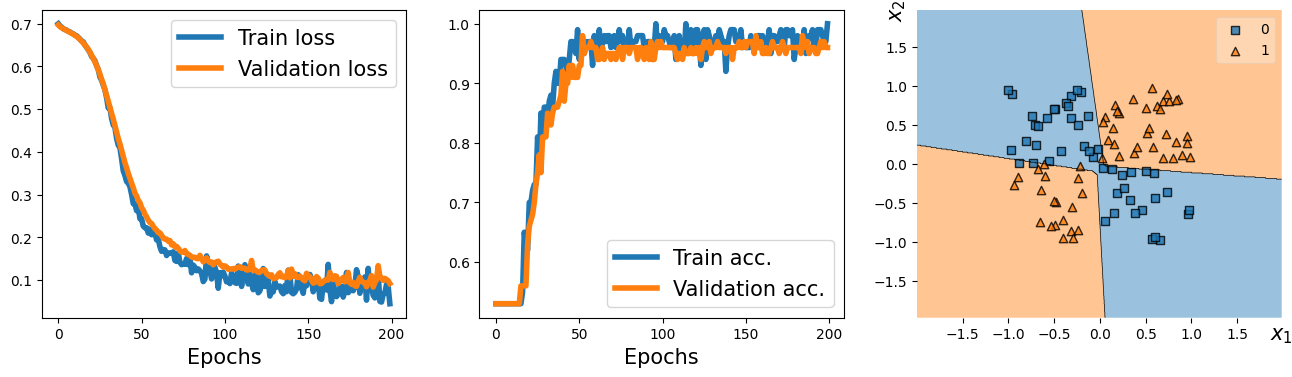

In [32]:
from mlxtend.plotting import plot_decision_regions


fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_valid, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(accuracy_hist_train, lw=4)
plt.plot(accuracy_hist_valid, lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

plt.show()